
## <div style="text-align: center">Neural Networks

---

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from imports_for_ML import *
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline

In [3]:
import tensorflow as tf

In [4]:
from keras.preprocessing.image import load_img, img_to_array

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.layers import Input,Dense,Conv2D,Add
from keras.layers import SeparableConv2D,ReLU
from keras.layers import BatchNormalization,MaxPool2D
from keras.layers import GlobalAvgPool2D
from keras.metrics import binary_accuracy

from keras import Model

In [6]:
import os

# remember to change the img_dir address!
img_dir = r'./train'
images = os.listdir(img_dir)
images[:3]

['dog.8011.jpg', 'cat.5077.jpg', 'dog.7322.jpg']

In [7]:
full_images = [os.path.join(img_dir, img) for img in images]

In [8]:
from imports_for_ML import load_images

X, y = load_images(img_dir, n_images=10000, resize=(50,50))

**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=23)

# Model 1

I decided to do literature reveiw and chose *XCEPTION* model implementation, considering this as best model for image recognition.

Below you can find architecture implementation with few changes in layers, despite the fact that application of XCEPTION model comes in tensorflow library.

- https://www.it4nextgen.com/keras-image-classification-models/
- https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568
- https://towardsdatascience.com/xception-from-scratch-using-tensorflow-even-better-than-inception-940fb231ced9

In [68]:
# creating the Conv-Batch Norm block

def conv_bn(x, filters, kernel_size, strides=(1,1)):
    
    x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

In [69]:
# creating separableConv-Batch Norm block

def sep_bn(x, filters, kernel_size, strides=(1,1)):
    
    x = SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

In [70]:
# entry flow

def entry_flow(x):
    
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, filters = 128, kernel_size =3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=728, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    return x

In [71]:
# middle flow

def middle_flow(tensor):
    
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        tensor = Add()([tensor,x])
        
    return tensor

In [106]:
# exit flow

def exit_flow(tensor):
    
    x = ReLU()(tensor)
    x = sep_bn(x, filters = 728,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 1024,  kernel_size=3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters =1024, kernel_size=1, strides =2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters = 1536,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 2048,  kernel_size=3)
    x = GlobalAvgPool2D()(x)
    
    x = Dense (units = 1, activation = 'sigmoid')(x)
    
    return x

In [112]:
# model code

input = Input(shape = (50,50,3))
x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

model = Model(inputs=input, outputs=output)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_108 (Conv2D)             (None, 25, 25, 32)   864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_455 (BatchN (None, 25, 25, 32)   128         conv2d_108[0][0]                 
__________________________________________________________________________________________________
re_lu_462 (ReLU)                (None, 25, 25, 32)   0           batch_normalization_455[0][0]    
___________________________________________________________________________________________

In [113]:
model.compile(loss = 'binary_crossentropy', optimizer  = 'adam', metrics = ['accuracy'])

In [114]:
history = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
282/282 [==============================] - 139s 462ms/step - loss: 0.7220 - accuracy: 0.6161
Epoch 2/10
282/282 [==============================] - 127s 450ms/step - loss: 0.5338 - accuracy: 0.7274
Epoch 3/10
282/282 [==============================] - 129s 456ms/step - loss: 0.4342 - accuracy: 0.8038
Epoch 4/10
282/282 [==============================] - 125s 445ms/step - loss: 0.3489 - accuracy: 0.8513
Epoch 5/10
282/282 [==============================] - 126s 447ms/step - loss: 0.2954 - accuracy: 0.8755
Epoch 6/10
282/282 [==============================] - 132s 468ms/step - loss: 0.2349 - accuracy: 0.9052
Epoch 7/10
282/282 [==============================] - 133s 472ms/step - loss: 0.1888 - accuracy: 0.9247
Epoch 8/10
282/282 [==============================] - 130s 460ms/step - loss: 0.1500 - accuracy: 0.9405
Epoch 9/10
282/282 [==============================] - 134s 474ms/step - loss: 0.1269 - accuracy: 0.9515
Epoch 10/10
282/282 [==============================] - 126s 446m

In [160]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Loss on the test data: {}%'.format(round(score[0], 2) * 100))
print('Accuracy on the test data: {}%'.format(round(score[1], 2) * 100))

Loss on the test data: 77.0%
Accuracy on the test data: 81.0%


# Summary

I wasn't happy with the result because loss was on high level, thus I decided to improve my model and try another approach. Below you can find reference.
- https://stackabuse.com/image-recognition-in-python-with-tensorflow-and-keras/

In [10]:
model2 = Sequential([
    Conv2D(32, (3, 3), padding='same', activation = 'relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    
    Conv2D(64, (3, 3), padding='same', activation = 'relu'),
    MaxPooling2D((3,3)),
    Dropout(0.2),
    

    Conv2D(128, (3, 3), padding='same', activation = 'relu'),
    MaxPooling2D((3,3)),
    Dropout(0.2),
   
# finally, we flatten all the filters to one vector and then add 64 ordinary neurons
    Flatten(input_shape = (5,5,64)),
    Dense(64, activation = 'relu'),

# and the output neuron that says dog (1) or cat (0)
    Dense(1, activation = 'sigmoid'),

])
# and compile, like always before
model2.compile(loss = 'binary_crossentropy', optimizer  = 'adam', metrics = ['accuracy'])


In [11]:
history2 = model2.fit(X_train, y_train, epochs=20, validation_split=0.33)

Epoch 1/20
189/189 [==============================] - 11s 56ms/step - loss: 5.4373 - accuracy: 0.5156 - val_loss: 0.6926 - val_accuracy: 0.4992
Epoch 2/20
189/189 [==============================] - 10s 53ms/step - loss: 0.6939 - accuracy: 0.5338 - val_loss: 0.6750 - val_accuracy: 0.6035
Epoch 3/20
189/189 [==============================] - 10s 53ms/step - loss: 0.6836 - accuracy: 0.5639 - val_loss: 0.6781 - val_accuracy: 0.5631
Epoch 4/20
189/189 [==============================] - 12s 63ms/step - loss: 0.6658 - accuracy: 0.5995 - val_loss: 0.6310 - val_accuracy: 0.6419
Epoch 5/20
189/189 [==============================] - 11s 56ms/step - loss: 0.6430 - accuracy: 0.6303 - val_loss: 0.6319 - val_accuracy: 0.6338
Epoch 6/20
189/189 [==============================] - 10s 56ms/step - loss: 0.6288 - accuracy: 0.6475 - val_loss: 0.6545 - val_accuracy: 0.6072
Epoch 7/20
189/189 [==============================] - 11s 56ms/step - loss: 0.6184 - accuracy: 0.6581 - val_loss: 0.6019 - val_accuracy:

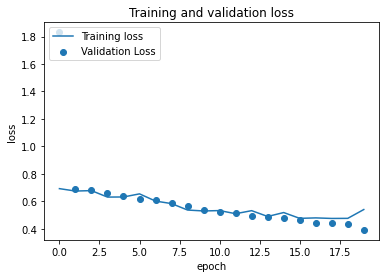

In [12]:
plt.scatter(history2.epoch,history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation Loss'], loc='upper left')
plt.show()

In [13]:
score = model2.evaluate(X_test, y_test)
print('Loss on the test data: {}%'.format(round(score[0], 2) * 100))
print('Accuracy on the test data: {}%'.format(round(score[1], 2) * 100))


32/32 [==============================] - 0s 9ms/step - loss: 0.5594 - accuracy: 0.7140
Loss on the test data: 56.00000000000001%
Accuracy on the test data: 71.0%


In [14]:
tf.keras.models.save_model(model=model2, filepath=r'./final_model', save_format='h5')

In [15]:
y_pred = model2.predict(X_test)

In [16]:
label_names = ['Cat', 'Dog']

In [17]:
display_X_test = X_test / 255

In [18]:
m = binary_accuracy(y_test, y_pred, threshold=0.15)

In [19]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(y_test, y_pred)
print("Binary Accuracy: ", m.result().numpy())

Binary Accuracy:  0.714


In [20]:
m = tf.keras.metrics.binary_accuracy(y_test, y_pred, threshold=0.5)
predictions = m.numpy() > 0.5 
predictions = predictions.astype(int)

In [28]:
correct_labels = [idx for idx, elem in enumerate(predictions) if elem == y_test[idx]]

In [29]:
random_correct_index = random.sample(correct_labels, 6)

In [30]:
incorrect_labels = [idx for idx, elem in enumerate(predictions) if elem != y_test[idx]]

In [31]:
random_incorrect_index = random.sample(incorrect_labels, 6)

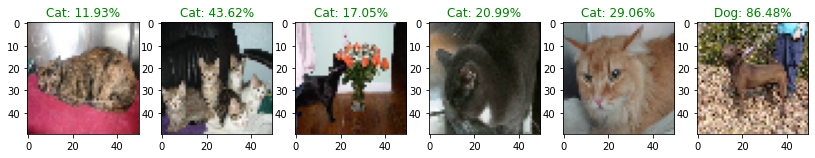

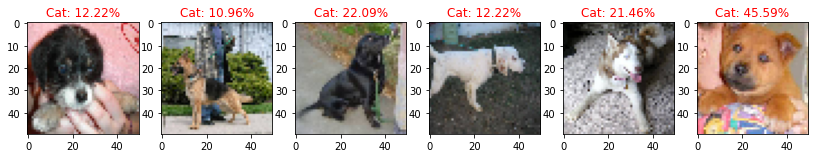

In [32]:
fig, ax = plt.subplots (ncols=6, figsize=(14, 6.5))

for idx, val in enumerate(random_correct_index):
    ax[idx].imshow(X_test[val] / 255, cmap='binary')
    ax[idx]. set_title('{}: {}%'.format(label_names[predictions[val]], round(float(y_pred[val]) *100, 2)), color='g')


fig, ax = plt.subplots (ncols=6, figsize=(14, 6.5))


for idx, val in enumerate(random_incorrect_index):
    ax[idx].imshow(X_test[val] / 255, cmap='binary')
    ax[idx]. set_title('{}: {}%'.format(label_names[predictions[val]], round(float(y_pred[val]) *100, 2)), color='r')
    
plt.show()

In [1]:
from keras.preprocessing.image import load_img, img_to_array

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [60]:
model = tf.keras.models.load_model('./final_model')

In [61]:
# My friend dog Yuki

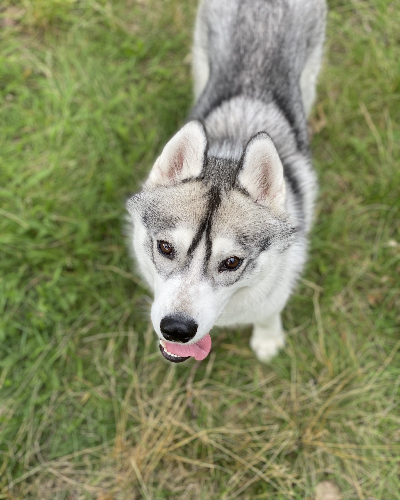

In [75]:
load_img('./test/dog.2.jpg',target_size=(500,400))

In [62]:
test_dog = img_to_array(load_img('./test/dog.2.jpg', target_size=(50,50)))

In [63]:
model.predict( np.array([test_dog]))

array([[0.6575111]], dtype=float32)

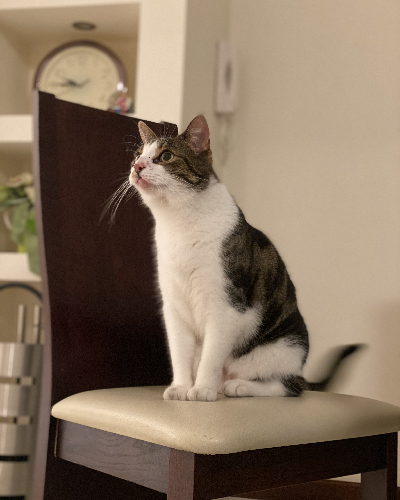

In [81]:
# My neighbours' chonkster Bazyl
load_img('./test/cat.1.jpg',target_size=(500,400))

In [82]:
test = img_to_array(load_img('./test/cat.1.jpg', target_size=(50,50)))
model.predict( np.array([test]))

array([[0.28648287]], dtype=float32)

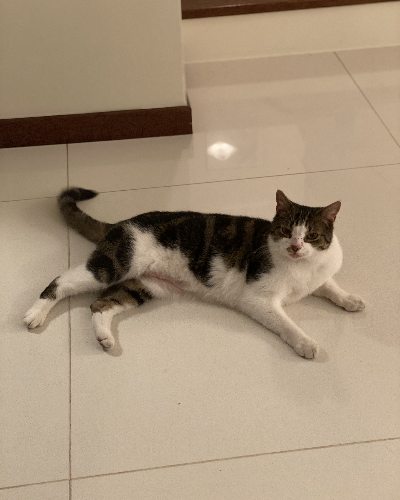

In [83]:
load_img('./test/cat.2.jpg',target_size=(500,400))

In [85]:
test = img_to_array(load_img('./test/cat.2.jpg', target_size=(50,50)))
model.predict( np.array([test]))

array([[0.13693568]], dtype=float32)

Those results are not perfect, but i'm happy with them